In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import os, csv
import pandas as pd

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

%run ../aux_funcs.py
%run ../RSRG.py
%run ../RSRG_class.py

In [2]:
log_file = pd.read_csv("log_file.csv")
ts_list = log_file['ts'].tolist()
log_file

,L,steps,"(a,b,w)",n_runs,ts
0,50,2375,"(0.1, 0.105, 4.0)",30,1677195497
1,50,2375,"(0.1, 0.105, 4.5)",30,1677195904
2,50,2375,"(0.1, 0.105, 5.0)",30,1677196328
3,50,2375,"(0.1, 0.105, 5.5)",30,1677196788
4,50,2375,"(0.1, 0.105, 6.0)",30,1677197254
5,50,2375,"(0.1, 0.105, 6.5)",30,1677197714


In [3]:
ts = str(ts_list[0])

with open("Ising_2D_output_"+ts+".pkl", "rb") as fp:   # Unpickling
    output_data = pickle.load(fp)

with open("Ising_2D_input_"+ts+".pkl", "rb") as fp:   
    input_dict = pickle.load(fp)
    
Omegas = np.array([])
dec_types = np.array([])
h_array, J_array = [], []


for core, item in enumerate(output_data):
    J_dist_list, h_dist_list, Omega_list_composite, decimation_type_composite = item
    Omegas = np.concatenate((Omegas, Omega_list_composite))
    dec_types = np.concatenate((dec_types, decimation_type_composite))
    if core==0:
        h_array = h_dist_list
        J_array = J_dist_list

    else:
        for i in range(len(input_dict['measure_list'])):
            h_array[i] = np.concatenate((h_array[i], h_dist_list[i]))
            J_array[i] = np.concatenate((J_array[i], J_dist_list[i]))
        
        
with open("Ising_2D_clusters_"+ts+".pkl", "rb") as fp:   
    clust_list_final = pickle.load(fp)
    
#print(input_dict)
clust_dict_list, reverse_dict_list = [], []

for core_pair in clust_list_final:
    clust_list_temp, reverse_list_temp = core_pair
    clust_dict_list+=clust_list_temp
    reverse_dict_list+=reverse_list_temp
    
largest_clust_list = np.array([max([len(clust) for clust in reverse_dict.values() if clust is not None]) for reverse_dict in reverse_dict_list])

#print(largest_clust_list.mean(), largest_clust_list.std())

In [4]:
ws = [4.0, 4.5, 5.0, 5.5, 6.0, 6.5]
largest_clust_size = [32.56666666666667, 21.933333333333334, 14.633333333333333, 11.533333333333333, 9.4, 8.066666666666666]
var_lcs = [11.572044859151827, 5.632840215103646, 3.6558932636984296, 2.2020192753218324, 1.854723699099141, 1.50406855635713]  

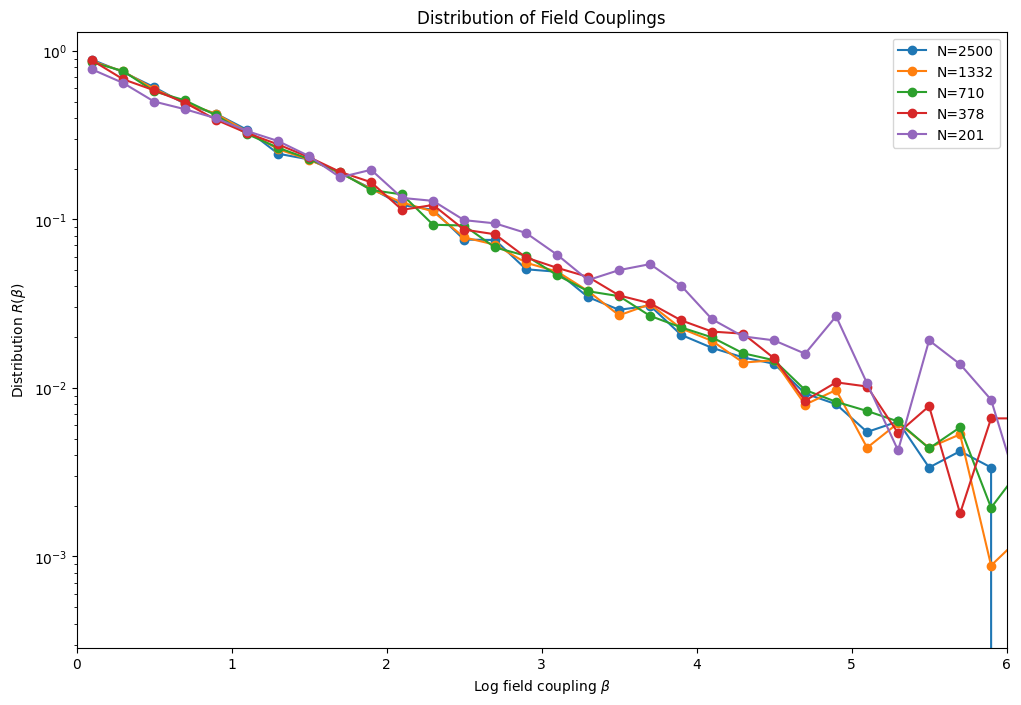

In [5]:
measure_list = input_dict['measure_list']
n_runs = input_dict['n_runs']
n_bins_h = 60

plt.figure(figsize=(12, 8))

for i,step in enumerate(measure_list):
    if i%4==0: 
        n,bins = np.histogram(h_dist_list[i], density=True, bins = n_bins_h, range=(0,12))
        width = bins[1]-bins[0]
        plt.plot((bins[1:]-width/2), n, label="N="+str(step), marker='o')

plt.yscale('log')
plt.xlim(0, 6)
#plt.ylim(1e-1, 1)

plt.xlabel(r"Log field coupling $\beta$")
plt.ylabel(r"Distribution $R(\beta)$")
plt.title("Distribution of Field Couplings")
plt.yscale('log')
plt.legend()

<ErrorbarContainer object of 3 artists>

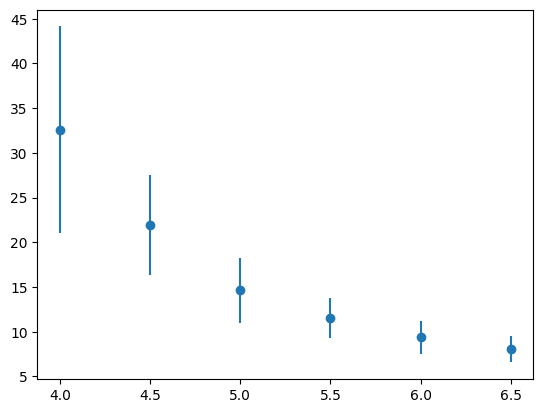

In [6]:
plt.errorbar(ws, largest_clust_size, yerr=var_lcs, marker='o', linestyle='')

In [32]:
def process_decimation_type(Omegas, dec_types, poly_degree = 4, convolve_window = 500):
    sorted_dec = np.array([x for _,x in sorted(zip(Omegas,dec_types))])
    sorted_Omegas = np.array(sorted(Omegas))

    window_size = convolve_window

    mask = np.ones(window_size)/window_size
    convolved_data=np.convolve(sorted_dec,mask,'same')

    poly = PolynomialFeatures(degree = poly_degree)

    poly_features = poly.fit_transform(sorted_Omegas.reshape(-1, 1))
    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, convolved_data)
    y_predicted = poly_reg_model.predict(poly_features)
    return y_predicted


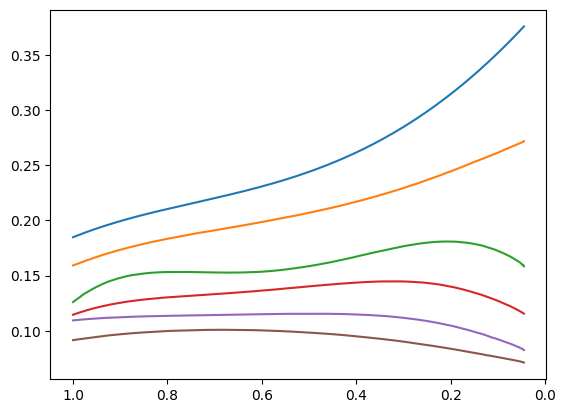

In [37]:
for ts in ts_list:
    with open("Ising_2D_output_"+str(ts)+".pkl", "rb") as fp:   # Unpickling
        output_data = pickle.load(fp)
    Omegas = np.array([])
    dec_types = np.array([])
    h_array, J_array = [], []


    for core, item in enumerate(output_data):
        J_dist_list, h_dist_list, Omega_list_composite, decimation_type_composite = item
        Omegas = np.concatenate((Omegas, Omega_list_composite))
        dec_types = np.concatenate((dec_types, decimation_type_composite))
        if core==0:
            h_array = h_dist_list
            J_array = J_dist_list

        else:
            for i in range(len(input_dict['measure_list'])):
                h_array[i] = np.concatenate((h_array[i], h_dist_list[i]))
                J_array[i] = np.concatenate((J_array[i], J_dist_list[i]))
    plt.plot(sorted_Omegas, process_decimation_type(Omegas, dec_types))
plt.gca().invert_xaxis()
#plt.ylim(0, 1)